# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflowjs as tfjs

# Read dataset
- dnn_bar_pass_prediction: The LSAT prediction from the DNN model.
- gender: Gender of the student.
- lsat: LSAT score received by the student.
- race: Race of the student.
- ugpa: A student's undergraduate GPA.
- pass_bar: - Ground truth label indicating whether the student eventually passed a bar.
- bar_passed - I added a boolean target column for convenience, of whether someone passed the bar at any point
- tier: tier of law school the student went to (higher is better)
- fam_inc: family income (broken up into quintiles)
- grad: whether someone graduated from or dropped out of law school
- fulltime: indicates students who attend law school full time
- decile: rank of student in their class in year 1 as a decile
- decile3: rank of student in their class in year 3 as a decile
- indxGrp: to be determined
- grad: whether a person graduated from law school

In [2]:
df = pd.read_csv('../data/bar_pass_prediction.csv')
df

,decile1b,decile3,ID,decile1,sex,race,cluster,lsat,ugpa,zfygpa,...,hisp,pass_bar,bar,bar_passed,tier,index6040,indxgrp,indxgrp2,dnn_bar_pass_prediction,gpa
0,10.0,10.0,2,10.0,1.0,7.0,1.0,44.0,3.5,1.33,...,0,1,a Passed 1st time,True,4.0,886.842082,g 700+,i 820+,0.979804,3.5
1,5.0,4.0,3,5.0,1.0,7.0,2.0,29.0,3.5,-0.11,...,0,1,a Passed 1st time,True,2.0,649.999987,f 640-700,f 640-700,0.979804,3.5
2,3.0,2.0,36,3.0,2.0,7.0,3.0,36.0,3.5,-0.64,...,0,1,a Passed 1st time,True,3.0,760.526298,g 700+,h 760-820,0.979804,3.5
3,7.0,4.0,52,7.0,2.0,7.0,3.0,39.0,3.5,0.34,...,0,1,a Passed 1st time,True,3.0,807.894717,g 700+,h 760-820,0.979804,3.5
4,9.0,8.0,55,9.0,2.0,7.0,4.0,48.0,3.5,1.02,...,0,1,a Passed 1st time,True,5.0,949.999974,g 700+,i 820+,0.979804,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22402,3.0,1.0,10695,3.0,2.0,3.0,6.0,26.5,1.8,-0.58,...,0,0,c Failed,False,1.0,440.526304,b 400-460,b 400-460,0.557568,1.8
22403,2.0,1.0,19642,3.0,2.0,3.0,6.0,19.7,1.8,-0.64,...,0,0,c Failed,False,1.0,333.157888,a under 400,a under 400,0.557568,1.8
22404,7.0,8.0,24704,7.0,2.0,3.0,3.0,36.0,1.8,0.41,...,0,1,a Passed 1st time,True,3.0,590.526298,e 580-640,e 580-640,0.557568,1.8
22405,10.0,10.0,10000,10.0,2.0,7.0,3.0,44.0,1.5,1.88,...,0,1,a Passed 1st time,True,3.0,686.842082,f 640-700,f 640-700,0.759128,1.5


# Data preprocessing

In [3]:
# What I'm doing next is filling in the missing decile values with information from the zfygpa column. I'll do that by creating a list of the minimum zfygpa values that scored in a certain decile and then filling the missing values with the decile score that scored above that minima.
df_zfy = df[['zfygpa', 'decile1']]
condlist = []

for i in range(1,11):
    condlist.append(df_zfy[df_zfy['decile1'] == i]['zfygpa'].min())

df['decile1'] = df.apply(lambda row: 9 if np.isnan(row['decile1']) & (row['zfygpa'] > .81) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 8 if np.isnan(row['decile1']) & (row['zfygpa'] > .51) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 7 if np.isnan(row['decile1']) & (row['zfygpa'] > .2) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 6 if np.isnan(row['decile1']) & (row['zfygpa'] > -.02) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 5 if np.isnan(row['decile1']) & (row['zfygpa'] > -.3) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 4 if np.isnan(row['decile1']) & (row['zfygpa'] > -.58) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 3 if np.isnan(row['decile1']) & (row['zfygpa'] > -.89) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 2 if np.isnan(row['decile1']) & (row['zfygpa'] > -1.3) else row['decile1'], axis = 1)
df['decile1'] = df.apply(lambda row: 1 if np.isnan(row['decile1']) & (row['zfygpa'] > -3.35) else row['decile1'], axis = 1)

In [4]:
# Same as above but for decile3 and zgpa
df_z = df[['zgpa', 'decile3']]
condlist = []

for i in range(1,11):
    condlist.append(df_z[df_z['decile3'] == i]['zgpa'].min())

df['decile3'] = df.apply(lambda row: 10 if np.isnan(row['decile3']) & (row['zgpa'] > 1.24) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 9 if np.isnan(row['decile3']) & (row['zgpa'] > .83) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 8 if np.isnan(row['decile3']) & (row['zgpa'] > .5) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 7 if np.isnan(row['decile3']) & (row['zgpa'] > .21) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 6 if np.isnan(row['decile3']) & (row['zgpa'] > -.05) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 5 if np.isnan(row['decile3']) & (row['zgpa'] > -.33) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 4 if np.isnan(row['decile3']) & (row['zgpa'] > -.6) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 3 if np.isnan(row['decile3']) & (row['zgpa'] > -.91) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 2 if np.isnan(row['decile3']) & (row['zgpa'] > -1.34) else row['decile3'], axis = 1)
df['decile3'] = df.apply(lambda row: 1 if np.isnan(row['decile3']) & (row['zgpa'] > -6.44) else row['decile3'], axis = 1)

In [5]:
# Fill missing gender data with male as the majority of the data is male
df['gender'].fillna('male', inplace=True)
df['gender'].replace('male', 1, inplace=True)
df['gender'].replace('female', 0, inplace=True)

# Fill missing race data with white as the majority of the data is white
# Use race1 as race column as this is the best representation
df['race1'].fillna('white', inplace=True)

df['tier'].fillna(3.0, inplace=True)
df['fam_inc'].fillna(4.0, inplace=True)

# Fill with column mean
df['decile3'].fillna(5, inplace=True)
df['decile1'].fillna(5, inplace = True)

df['grad'] = df['grad'].replace(['Y', 'X', 'O'], [1, 0, 0])
df = df.drop('Dropout', axis=1)

df['grad'] = df['grad'].fillna(1)
df['fulltime'].fillna(1.0, inplace=True)
df['fulltime'] = df['fulltime'].replace(2, 0)

In [6]:
df['indxgrp'].replace({'g 700+': 7, 'f 640-700': 6, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3, 'b 400-460': 2, 'a under 400': 1}, inplace=True)
df['indxgrp2'].replace({'i 820+': 9, 'f 640-700': 6, 'h 760-820': 8, 'g 700-760': 7, 'e 580-640': 5, 'd 520-580': 4, 'c 460-520': 3, 'b 400-460': 2, 'a under 400': 1}, inplace=True)

In [7]:
# Drop ID column as this has no value for a model
# ugpa and gpa are identical and neither have missing values. Drop gpa.
# male and bar_passed are dupes of pass_bar and gender and parttime is the opposite of fulltime, so drop them (male, bar_passed and parttime).
# sex is pretty much the same as gender. Drop it!
# It looks like there are no values missing in decile1 that are present in decile1b, so I'm dropping decile1b
# Drop DOB_yr, cluster, index6040 and age as they have little to no correlation with pass_bar
# bar1, bar1_yr, bar2, bar2_yr and bar are either duplicates of pass_bar or give info on when a student passed the bar, so they wouldn't have predictive value. I'm dropping them.
df.drop(columns=['race', 'race2', 'other', 'asian', 'black', 'hisp', 'ID', 'gpa', 'parttime', 'male', 'bar_passed', 'sex', 'decile1b', 'zfygpa', 'zgpa', 'DOB_yr','age', 'cluster', 'bar1', 'bar1_yr', 'bar2', 'bar2_yr', 'bar', 'index6040', 'dnn_bar_pass_prediction'], axis=1, inplace=True)

In [8]:
df[['decile3', 'decile1', 'lsat', 'grad', 'fulltime', 'fam_inc', 'tier']] = df[['decile3', 'decile1', 'lsat', 'grad', 'fulltime', 'fam_inc', 'tier']].astype(int)

In [9]:
df = pd.get_dummies(df, columns=['race1'])

<AxesSubplot:>

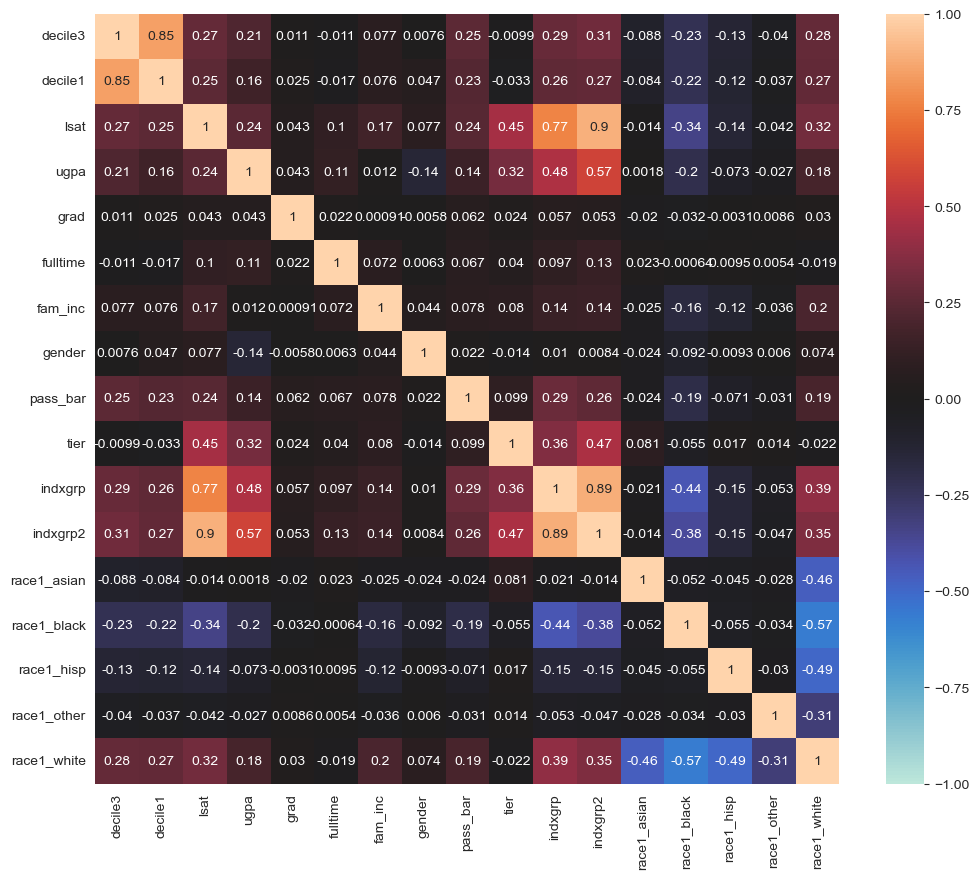

In [10]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0)

In [11]:
# Shuffle data to prevent none existent order corr
df = df.sample(frac=1, random_state=1)

# Split dataset into target variable and features
df_y = df['pass_bar']
df_X = df.drop('pass_bar', axis=1)

# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)
X_train

,decile3,decile1,lsat,ugpa,grad,fulltime,fam_inc,gender,tier,indxgrp,indxgrp2,race1_asian,race1_black,race1_hisp,race1_other,race1_white
13637,5,6,36,3.7,1,1,4,0,2,7,8,0,0,0,0,1
11867,5,8,40,2.8,1,1,5,1,4,7,7,0,0,0,0,1
18052,2,1,31,3.0,1,1,3,0,5,5,5,0,0,0,0,1
5668,10,10,38,3.3,1,1,4,1,3,7,8,0,0,0,0,1
9952,1,1,42,3.6,1,1,4,1,5,7,9,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18966,3,5,35,3.0,1,1,4,0,4,6,6,0,0,0,0,1
6358,5,3,44,3.2,1,1,1,0,6,7,9,0,1,0,0,0
3979,2,3,39,3.4,1,1,4,0,4,7,8,0,0,0,0,1
484,2,1,35,3.5,1,1,3,0,4,7,7,0,0,0,0,1


# Functions

In [12]:
# Function that plots the confusion matrix in a more readable style
def pretty_confusion_matrix(y_true, y_pred, labels=["False", "True"]):
    cm = confusion_matrix(y_true, y_pred)
    pred_labels = ['Predicted ' + l for l in labels]
    df = pd.DataFrame(cm, index=labels, columns=pred_labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df, cmap="YlGnBu", annot=True, linewidths=.5, fmt='g', ax=ax)


# Function that allows to plot the loss over time (epochs)
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Change of training and validation loss over time")
    plt.show()


# Function that allows to plot the accuracy over time (epochs)
def plot_accuracy(history):
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Change of training and validation accuracy over time")
    plt.show()


# Function for printing accuracy of a model on the train and test set
def print_loss_and_accuracy(model, X_train, y_train, X_test, y_test):
    print('Train:')
    model.evaluate(X_train, y_train)
    print('Test:')
    model.evaluate(X_test, y_test)

# Ideal Model

In [13]:
model = Sequential()
model.add(Dense(1, input_shape=(16,), activation='softmax'))
model.compile(Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, verbose=0)
print_loss_and_accuracy(model, X_train, y_train, X_test, y_test)

Train:
491/491 [==============================] - 0s 859us/step - loss: 0.1533 - accuracy: 0.9487
Test:
211/211 [==============================] - 0s 902us/step - loss: 0.1531 - accuracy: 0.9459


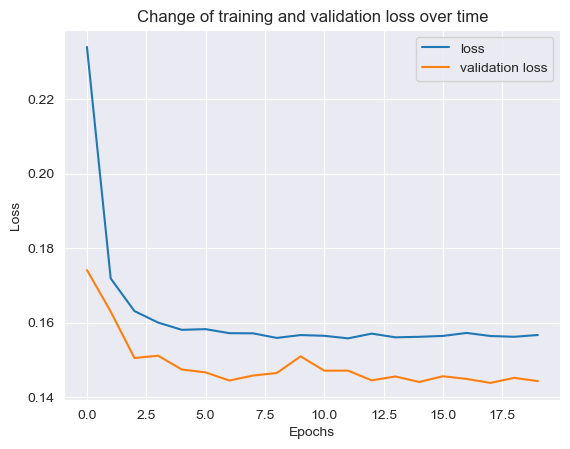

In [14]:
plot_loss(history)

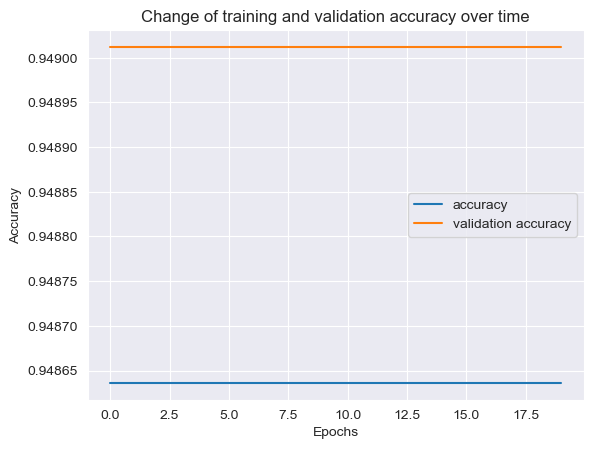

In [15]:
plot_accuracy(history)

# Realistic model

In [16]:
df_X = df_X[['decile3', 'decile1', 'lsat', 'ugpa', 'fulltime', 'grad']]

# Split the data into a train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=42)

model = Sequential()
model.add(Dense(1, input_shape=(6,), activation='sigmoid'))
model.compile(Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, verbose=0)
print_loss_and_accuracy(model, X_train, y_train, X_test, y_test)

Train:
491/491 [==============================] - 0s 929us/step - loss: 0.1547 - accuracy: 0.9485
Test:
211/211 [==============================] - 0s 769us/step - loss: 0.1542 - accuracy: 0.9481


# Prediction

In [27]:
# The range of values of the lsat in this dataset do not correspond with real-life data. In this dataset it ranges from 0-60 (educated guess). The range from the real lsat is 120-180 (which comes to 60 inbetween). So to calculate an accurate lsat score for a prediction 120 points must be deducted from provided real-life lsat score.
# Good student
print(model.predict([[5, 5, 35, 3, True, True]]))
# bad student
print(model.predict([[1, 1, 14, 2, False, True]]))

1/1 [==============================] - 0s 28ms/step
[[0.96026033]]
1/1 [==============================] - 0s 28ms/step
[[0.11294796]]


# Export model

In [ ]:
tfjs.converters.save_keras_model(model, 'binaryClassificationBarPass_tfjs_model')

In [ ]:
model.save("binaryClassificationBarPass.h5")